In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from qutip.ipynbtools import version_table
from tqdm.notebook import tqdm
from matplotlib.animation import FuncAnimation

resol = 200
pi = np.pi
version_table()

Software,Version
QuTiP,5.1.1
Numpy,1.26.2
SciPy,1.11.3
matplotlib,3.7.3
Number of CPUs,11
BLAS Info,Generic
IPython,8.17.2
Python,"3.12.0 (v3.12.0:0fb18b02c8, Oct 2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]"
OS,posix [darwin]
Cython,3.0.11


<h1> RG solver </h1>

In [2]:
def runge_kutta_scheme(H, init_state, times, progress_bar=True):
    """
    Runge-Kutta scheme for the time evolution of a quantum state

    ---Parameters---
    H : function
        H(t) return the Hamiltonian (qObj) at time t
    init_state : qObj
        initial state
    times : array
        array of times

    ---Returns---
    state_list : list
        list of states at each time
    """

    state_list = [init_state]
    dt = times[1] - times[0]

    for i in tqdm(range(1, len(times)), disable=not progress_bar):
        
        current_state = state_list[-1].full().flatten()
        t = times[i]
        H_0 = H(t)
        H_1 = H(t + dt/2)
        H_2 = H(t + dt)

        k1 = -1j*dt*H_0 @ current_state
        k2 = -1j*dt*H_1 @ (current_state + k1/2)
        k3 = -1j*dt*H_1 @ (current_state + k2/2)
        k4 = -1j*dt*H_2 @ (current_state + k3)

        new_state = current_state + (k1 + 2*k2 + 2*k3 + k4)/6
        #enforce normalization
        new_state = qt.Qobj(new_state).unit()
        state_list.append(new_state)
       
    return state_list

<h1> Conduct time evolution </h1>

In [50]:
def get_data_mirror(L, T, dt, omega_0, omega_A, omega_max, n_A, g_0, x_A, sigma, x_0, use_WW_approx, progress_bar = True):
    #quantization of the modes
    omega_tab_p = np.array([2*pi*n/L for n in range(1000000) if 2*pi*n/L <= omega_max])
    k_tab = np.sort(np.unique(np.concatenate((-omega_tab_p, omega_tab_p))))
    omega_tab = np.abs(k_tab)
    n_modes = len(k_tab)
    print("Number of modes: ", n_modes)

    #tab of couplings
    g_tab = np.zeros((n_modes, n_A), dtype=complex)
    for i in range(n_modes):
        for j in range(n_A):
            if use_WW_approx:
                g_tab[i, j] = g_0*np.sqrt(omega_A / L)*np.exp(-1j*x_A*k_tab[i])*1j
            else:
                g_tab[i, j] = g_0*np.sqrt(omega_tab[i] / L)*np.exp(-1j*x_A*k_tab[i])*1j #in my case, g is independant of the atom index

    #Creation of the Hamiltonian
    dim_subspace = n_modes + n_A

    def H(t):
        H_matrix = np.zeros((dim_subspace, dim_subspace), dtype=complex)

        ##of diagonal elements
        for i in range(n_modes):
            for j in range(n_A):
                H_matrix[n_modes+j, i] = g_tab[i, j] * np.exp(-1j*(omega_tab[i] - omega_A)*t)
                H_matrix[i, n_modes+j] = np.conjugate(H_matrix[n_modes+j,i])
        
        return H_matrix

    ##Operators of interest
    occupation_nb_photon_momentum_list = []
    occupation_nb_total_atom = 0

    #occupation number operators in momentum space
    for i in range(n_modes):
        occupation_nb_photon_momentum_list.append(qt.basis(dim_subspace, i) * qt.basis(dim_subspace, i).dag())

    #occupation number atoms
    for j in range(n_A):
        occupation_nb_total_atom += qt.basis(dim_subspace, n_modes + j) * qt.basis(dim_subspace, n_modes + j).dag()
    

    ##Initial state
    k_bar = k_tab[np.argmin(np.abs(k_tab - omega_0))]

    init_state = 0
    for i in range(n_modes):
        init_state += np.exp(-0.5*sigma**2*(k_tab[i] - k_bar)**2 -1j * k_tab[i] * x_0) * qt.basis(dim_subspace, i)
    init_state = init_state.unit()
    
    #time evolution
    nb_pts = int(T/dt)
    times = np.linspace(0, T, nb_pts)
    state_list = runge_kutta_scheme(H, init_state, times, progress_bar=progress_bar)

    #data extraction
    N_k_tab = np.zeros((n_modes, nb_pts))
    N_A_tab = np.zeros(nb_pts)

    print("Extracting expectation values..")
    for i in tqdm(range(nb_pts)):
        state = state_list[i]
        for j in range(n_modes):
            N_k_tab[j, i] = qt.expect(occupation_nb_photon_momentum_list[j], state)

        N_A_tab[i] = qt.expect(occupation_nb_total_atom, state)
    
    return times, k_tab, state_list, N_k_tab, N_A_tab


Test the function

In [60]:
L = 5*pi
T = L/2
dt = 0.05
#number of atom
n_A = 1
x_A = 0

#width of the wave packet
sigma = L/16
x_0 = -L/4


#Jaynes-Cummings parameter g_0 and energies 
g_0 = 0.1
omega_A = 30
omega_0 = 30
omega_max = 2*omega_A
omega_max_axis = 1.1*10*omega_0

print("Coupling parameter at atom frequency: ", g_0*np.sqrt(omega_A / L))
print("delta_k = ", 2*pi/L)
print("number of time points = ", int(T/dt))

use_WW_approx = True
dt = 0.001
times, k_tab, state_list, N_k_tab, N_A_tab = get_data_mirror(L, T, dt, omega_0, omega_A, omega_max, n_A, g_0, x_A, sigma, x_0, use_WW_approx)

Coupling parameter at atom frequency:  0.1381976597885342
delta_k =  0.4
number of time points =  157
Number of modes:  301


  0%|          | 0/7852 [00:00<?, ?it/s]

Extracting expectation values..


  0%|          | 0/7853 [00:00<?, ?it/s]

<h1> Wave function </h1>

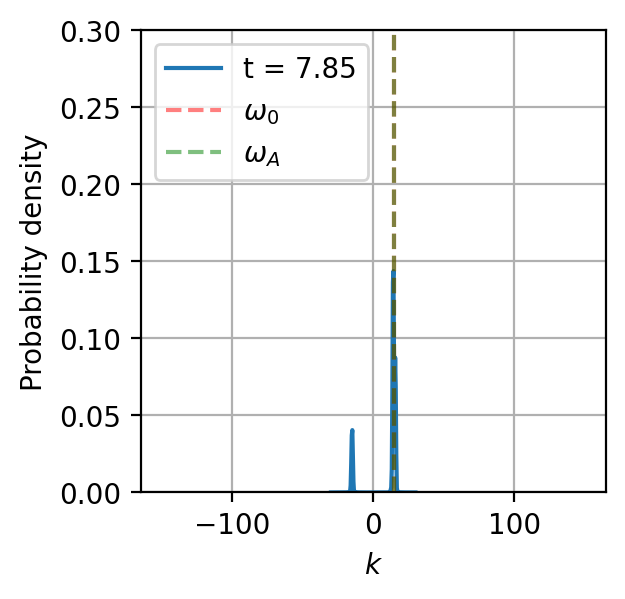

In [57]:
t_index = -1
N_k_tab = np.array(N_k_tab)
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)

#evolution of the probability density in position sp§ace
ax.plot(k_tab, N_k_tab[:,t_index], label="t = {:.2f}".format(times[t_index]))
ax.set_xlim(-omega_max_axis, omega_max_axis)
ax.set_ylim(0, 0.3)
ax.vlines(omega_0, 0, 1, color='r', linestyle='--', label=r'$\omega_0$', alpha=0.5)
ax.vlines(omega_A, 0, 1, color='g', linestyle='--', label=r'$\omega_A$', alpha=0.5)
ax.legend(loc='upper left')
ax.set_xlabel(r'$k$')   
ax.set_ylabel('Probability density')

ax.grid()


plt.show()

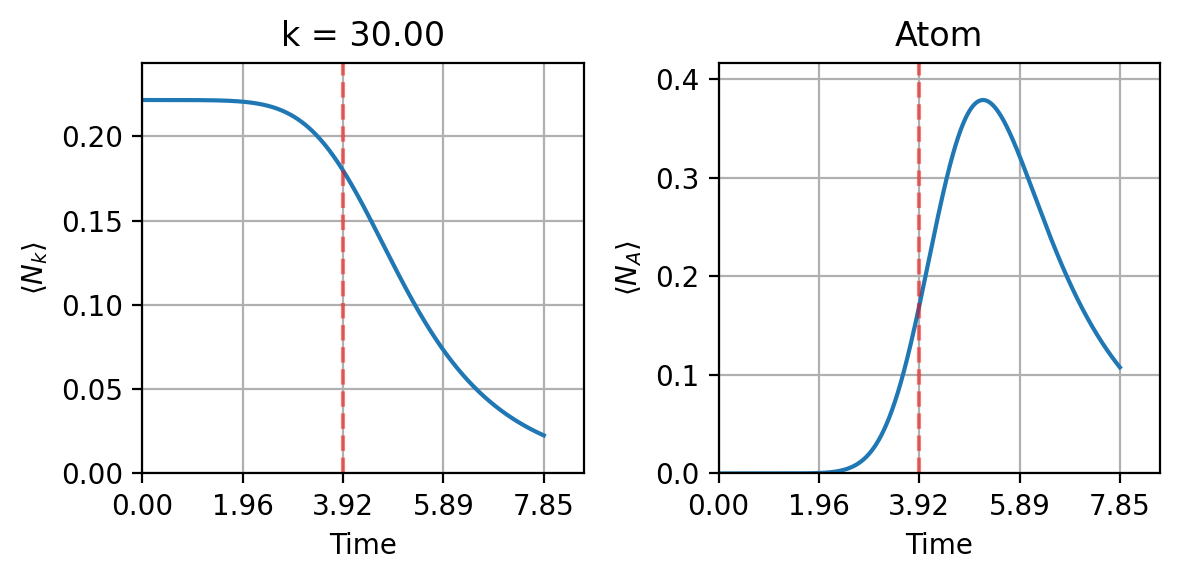

In [61]:
k_target = omega_0
k_index = np.argmin(np.abs(k_tab - k_target))

fig, ax = plt.subplots(1,2, figsize=(6,3), dpi=resol)

ax[0].plot(times, N_k_tab[k_index,:])
ax[0].set_xlim(0, 1.1*times[-1])
ax[0].set_xticks(np.floor(100*np.array([0, T/4, T/2, 3*T/4, T]))/100)
ax[0].set_xlabel('Time')
ax[0].vlines(T/2, 0, 1, color='r', linestyle='--', alpha=0.5)
ax[0].set_ylim(0, 1.1*np.max(N_k_tab[k_index,:]))
ax[0].set_ylabel(r'$\langle N_k \rangle$')
ax[0].set_title("k = {:.2f}".format(k_tab[k_index]))
ax[0].grid()

ax[1].plot(times, N_A_tab)
ax[1].set_xlim(0, 1.1*times[-1])
ax[1].set_xticks(np.floor(100*np.array([0, T/4, T/2, 3*T/4, T]))/100)
ax[1].set_xlabel('Time')
ax[1].vlines(T/2, 0, 1, color='r', linestyle='--', alpha=0.5)
ax[1].set_ylim(0, 1.1*np.max(N_A_tab))
ax[1].set_ylabel(r'$\langle N_A \rangle$')
ax[1].set_title("Atom")
ax[1].grid()

fig.tight_layout()
plt.show()

<h1> Reflection and transmission </h1>

T =  0.3333616138200033
R =  0.558934502991825


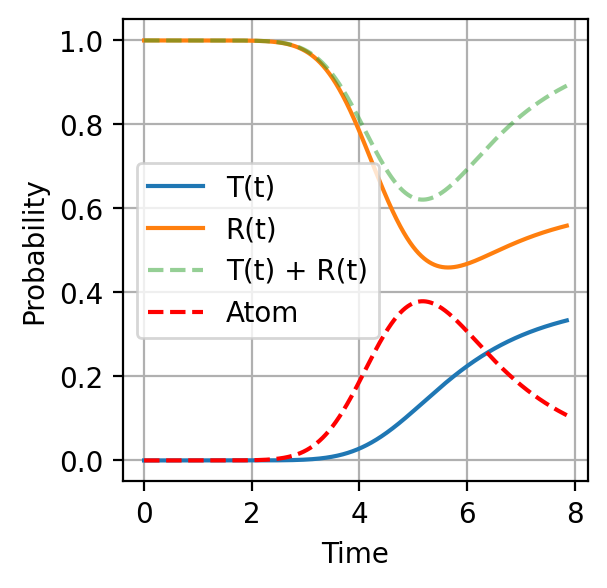

In [62]:
nb_pts = len(times)
T = np.zeros(nb_pts)
R = np.zeros(nb_pts)
n_modes = N_k_tab.shape[0]

for t in range(nb_pts):
    for x in range(n_modes): 
        if k_tab[x] < 0:
            T[t] += N_k_tab[x, t]
        else:
            R[t] += N_k_tab[x, t]
            
print("T = ", T[-1])
print("R = ", R[-1])

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)
ax.plot(times, T, label='T(t)')
ax.plot(times, R, label='R(t)')
ax.plot(times, T+R, label='T(t) + R(t)', linestyle='--', alpha=0.5) 
ax.plot(times, N_A_tab, label='Atom', linestyle='--', color='red')   
ax.set_xlabel('Time')
ax.set_ylabel('Probability')
ax.legend()
ax.grid()

plt.show()

<h1> Varying detunning </h1>

In [80]:
L = 5*pi
dt = 0.05
N = 64
T = L/2
#number of atom
n_A = 1
x_A = 0

g_0 = 1
omega_A = 5

#width of the wave packet
sigma = L/8
x_0 = -L/4

#modes quantization
n_modes = 64
use_WW_approx = True

nb_freq = 50
omega_0_tab = np.linspace(0, 10, nb_freq)
reflection_tab = np.zeros(nb_freq)

for i in tqdm(range(nb_freq)):
    omega_0 = omega_0_tab[i]
    #conduct time evolution
    times, state_list, N_k_tab, N_x_tab, N_A_tab = get_data_mirror(L, N, T, dt, n_modes, omega_0, omega_A, n_A, g_0, x_A, sigma, x_0, use_WW_approx, progress_bar=False)
    #get the
    position_lattice_list = np.linspace(-L/2, L/2, N)
    nb_pts = len(times)
    reflection_coef = 0
    for x in range(N):
        if position_lattice_list[x] <= 0:
            reflection_coef += N_x_tab[x,-1]
    reflection_tab[i] = reflection_coef

  0%|          | 0/50 [00:00<?, ?it/s]

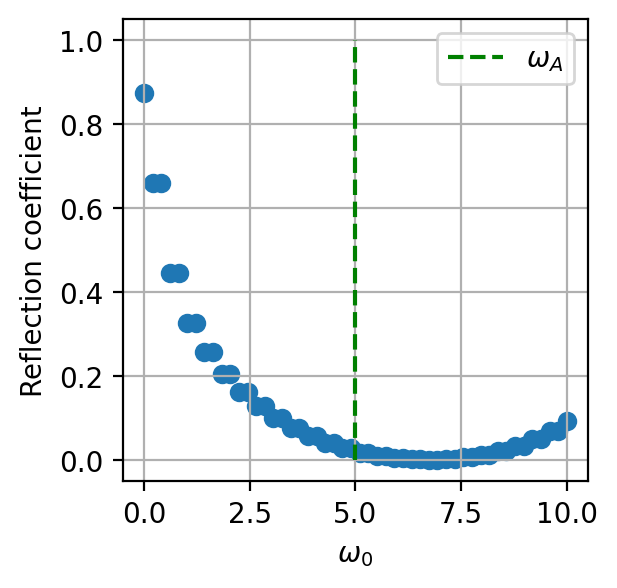

In [83]:
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)   
ax.scatter(omega_0_tab, reflection_tab)
ax.vlines(omega_A, 0, 1, color='green', linestyle='--', label='$\\omega_A$')
ax.set_xlabel('$\\omega_0$')
ax.set_ylabel('Reflection coefficient')
ax.grid()
ax.legend()

plt.show()